This notebook is based on the [Getting Started tutorial](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) from [stim](https://github.com/quantumlib/Stim). We adapt it to use a phenomenological noise model.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import stim
import pymatching

In [154]:
def repetition_code_circuit(d: int, p: float, prep_state: int = 0, depolarize: bool = False) -> stim.Circuit:
    """A single round of repetition code syndrome extraction proceeded by
    a bit-flip noise model on the data qubits."""

    assert d >= 3
    assert d % 2 != 0
    assert prep_state in set([0, 1])
    assert p >= 0. and p <= 1.

    data_qubits = list(range(0, 2 * d, 2))
    measure_qubits = list(range(1, 2 * d - 1, 2))

    ckt = stim.Circuit()
    for q in sorted(data_qubits + measure_qubits):
        ckt.append("R", q)
    # Prepare the 0 or 1 state.
    if prep_state == 1:
        ckt.append("X", [0])
        cnot_targets = []
        for i in range(1, len(data_qubits)):
            cnot_targets += [data_qubits[i-1], data_qubits[i]]
        ckt.append("CX", cnot_targets)
        ckt.append("TICK")
    # Add a round of noise.
    if depolarize:
        ckt.append("DEPOLARIZE1", data_qubits, arg=p)
    else:
        ckt.append("X_ERROR", data_qubits, arg=p)
    ckt.append("TICK")
    # Add a round of syndrome extraction and observable measurement.
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq-1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq+1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    ckt.append("M", measure_qubits)
    # Add detectors for the syndrome measurments
    for i, mq in enumerate(measure_qubits):
        ckt.append_from_stim_program_text(f"DETECTOR({mq}, 0) rec[{-i - 1}]")
    # Add detectors and an observable for the data qubits.
    ckt.append("M", data_qubits)
    for i, dq in enumerate(data_qubits[:-1]):
        ckt.append_from_stim_program_text(f"DETECTOR({dq}, 1) rec[{-i - 2}] rec[{-i - 1}] rec[{-i - d - 1}]")
    ckt.append_from_stim_program_text(f"OBSERVABLE_INCLUDE(0) rec[-1]")
    return ckt

R 0 1 2 3 4
X_ERROR(0.5) 0 2 4
TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
M 1 3
DETECTOR(1, 0) rec[-1]
DETECTOR(3, 0) rec[-2]
M 0 2 4
DETECTOR(0, 1) rec[-2] rec[-1] rec[-4]
DETECTOR(2, 1) rec[-3] rec[-2] rec[-5]
OBSERVABLE_INCLUDE(0) rec[-1]


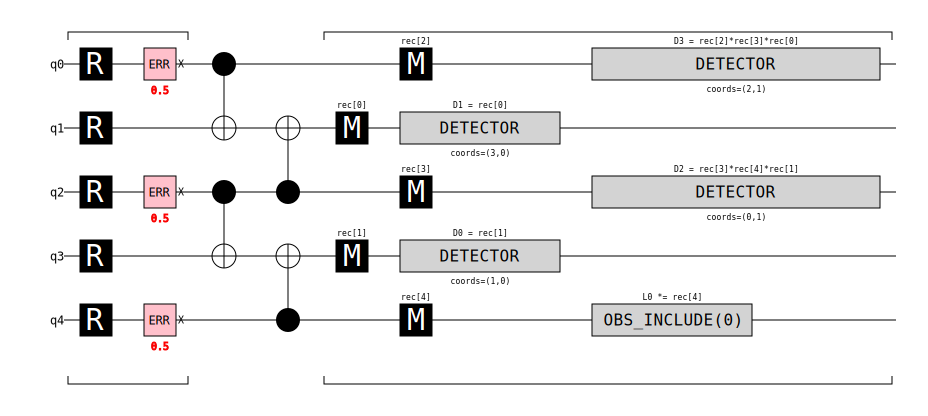

In [155]:
rep_ckt = repetition_code_circuit(3, 0.5, prep_state=0)
print(rep_ckt)
rep_ckt.diagram('timeline-svg')

In [156]:
shot_sampler = rep_ckt.compile_sampler()
shot_samples = shot_sampler.sample(shots=10)
print("Measurement samples:")
for sample in shot_samples:
    bitstring = ["1" if b else "0" for b in sample]
    print("".join(bitstring))

detector_sampler = rep_ckt.compile_detector_sampler()
detector_samples = detector_sampler.sample(shots=10)
print("Detector samples:")
for sample in detector_samples:
    dstrings = ["!" if b else "_" for b in sample]
    print("".join(dstrings))

Measurement samples:
11010
01110
10100
10011
11010
11010
11010
00111
10100
11101
Detector samples:
_!__
!!__
____
_!__
____
____
____
____
_!__
!!__


In [157]:
dem = rep_ckt.detector_error_model()
print(dem)

error(0.5) D0 D1
error(0.5) D0 L0
error(0.5) D1
detector(1, 0) D0
detector(3, 0) D1
detector(0, 1) D2
detector(2, 1) D3


In [158]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [159]:
lers = count_logical_errors(rep_ckt, 10_000)
print(lers)

4965


R 0 1 2 3 4
TICK
DEPOLARIZE1(0.1) 0 2 4
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
MR 1 3
DETECTOR(1, 0) rec[-2]
DETECTOR(3, 0) rec[-1]
M 0 2 4
DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
OBSERVABLE_INCLUDE(0) rec[-1]


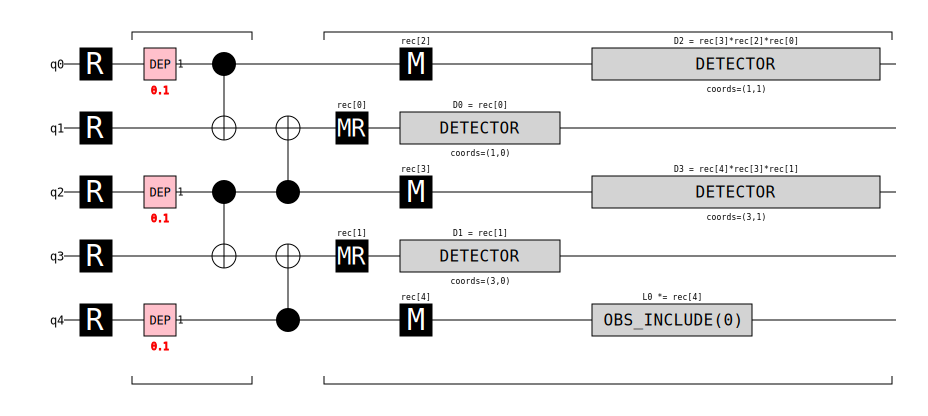

In [160]:
d = 3
p = 0.1
stim_ckt = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=1,
    distance=d,
    before_round_data_depolarization=p,
    before_measure_flip_probability=0.
)
print(stim_ckt)
stim_ckt.diagram('timeline-svg')

In [163]:
ds = [3, 5, 7]
probs = np.linspace(0., 0.6, num=10)
shots = 10_000
stim_lers = np.zeros((len(ds), len(probs)))
my_lers = np.zeros((len(ds), len(probs)))

for i, d in enumerate(ds):
    for j, p in enumerate(probs):
        my_ckt = repetition_code_circuit(d, p, depolarize=True)
        stim_ckt = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=1,
            distance=d,
            before_round_data_depolarization=p,
            before_measure_flip_probability=0.
        )
        my_num_errors = count_logical_errors(my_ckt, shots)
        stim_num_errors = count_logical_errors(stim_ckt, shots)
        my_lers[i, j] = float(my_num_errors) / float(shots)
        stim_lers[i, j] = float(stim_num_errors) / float(shots)

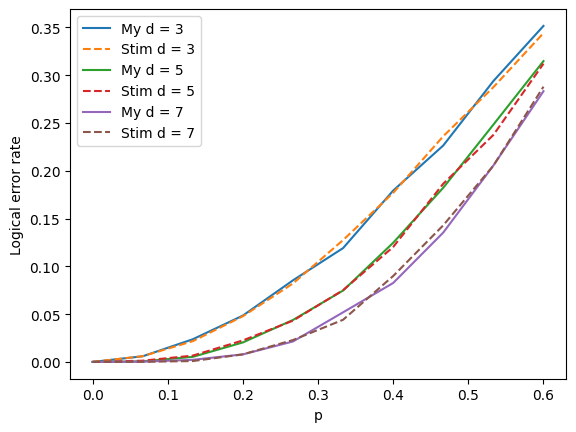

In [164]:
fig, ax = plt.subplots()

for i, d in enumerate(ds):
    ax.plot(probs, my_lers[i, :], '-', label=f"My d = {d}")
    ax.plot(probs, stim_lers[i, :], '--', label=f"Stim d = {d}")

ax.set_ylabel("Logical error rate")
ax.set_xlabel("p")
plt.legend()